In [1]:
#Package
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train=pd.read_csv("merged_train.csv")
test=pd.read_csv("merged_test.csv")

In [3]:
print(len(set(train.단지코드)), len(set(test.단지코드)))

414 147


In [4]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [5]:
print(train.shape, test.shape)

(2577, 34) (936, 33)


## 상가비율, 대형전용면적, 세대당가능주차면수, 공가수

In [6]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)

...After preprocessing
(2577, 38) (936, 37)


In [7]:
train['0~19 인구수'] = train['0~19세_비율']*train['총세대수']
train['20~39 인구수'] = train['20~39세_비율']*train['총세대수']
train['40~69 인구수'] = train['40~69세_비율']*train['총세대수']
train['70세이상 인구수'] = train['70세이상_비율']*train['총세대수']
test['0~19 인구수'] = test['0~19세_비율']*test['총세대수']
test['20~39 인구수'] = test['20~39세_비율']*test['총세대수']
test['40~69 인구수'] = test['40~69세_비율']*test['총세대수']
test['70세이상 인구수'] = test['70세이상_비율']*test['총세대수']

In [8]:
def func3(x,dic):
    for i in dic.keys():
        if len(dic[i]) == len(x):
            if all(dic[i] == x):
                return i

In [9]:
train.loc[train['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'
test.loc[test['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'

train.loc[train['공급유형'].isin(['공공임대(10년)', '공공임대(5년)']),'공급유형'] = '공공임대(단기)'
test.loc[test['공급유형'].isin(['공공임대(10년)', '공공임대(5년)']),'공급유형'] = '공공임대(단기)'

no_shop = train[train['공급유형']!='임대상가']
uniq = np.reshape(no_shop['공급유형'].unique(),(7,1))

dic = dict(enumerate(uniq))
dic[8] = ['공공임대(단기)', '국민임대']
dic[9] = ['장기전세', '국민임대', '영구/행복']
dic[10] = ['국민임대', '영구/행복']
dic[11] = ['공공임대(단기)', '공공임대(분납)']
dic[12] = ['공공분양', '공공임대(단기)', '공공임대(분납)']
dic[13] = ['공공임대(50년)', '영구/행복']
dic[14] = ['장기전세', '공공임대(단기)', '공공임대(분납)']

# dic1

dic1 = dict()
for i in dic.keys():
    val = train.loc[train['공급유형'].isin(dic[i]),'임대료'].mean()
    dic1[i] = val

# train
no_shop = train[train['공급유형']!='임대상가']
sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
sample['cluster'] = sample['cluster'].apply(lambda x: int(x))
train = pd.merge(train,sample[['단지코드','cluster']],on='단지코드',how='left')
train['cluster'] = train['cluster'].apply(lambda x: dic1[x])
#train = train.drop(['공급유형'],axis=1)


# test
no_shop = test[test['공급유형']!='임대상가']
sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
test = pd.merge(test,sample[['단지코드','cluster']],on='단지코드',how='left')
test['cluster'] = test['cluster'].apply(lambda x: dic1[x])
#test = test.drop(['공급유형'],axis=1)

# 자격유형

In [10]:
dic = {'1': 'A' ,'2':['C','F','G'],'3':['B','H','I'],'4':['J'],
       '5':['L',"M","N","O"],'6':["E","K"],'7':'D'}

In [11]:
def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

In [12]:
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)
train= train.drop(columns="자격유형")
test= test.drop(columns="자격유형")

# 공급유형

In [13]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [14]:
train.shape, test.shape

((2577, 43), (936, 42))

# 장기전세, 공공분양 drop

In [15]:
pd.concat([pd.DataFrame(train.공급유형.value_counts()), pd.DataFrame(test.공급유형.value_counts())], axis=1)

,공급유형,공급유형
국민임대,1708,611.0
영구/행복,341,160.0
임대상가,286,112.0
공공임대(단기),183,34.0
공공임대(50년),31,13.0
공공임대(분납),12,6.0
장기전세,9,NaN
공공분양,7,NaN


In [16]:
train=train[train.공급유형!="장기전세"]
train=train[train.공급유형!="공공분양"]

# 1차원

In [17]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명', '도로명주소',
       '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수', '총인구수',
       '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상',
       '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수',
       '공가수비율', '대형전용면적', '0~19 인구수', '20~39 인구수', '40~69 인구수', '70세이상 인구수',
       'cluster', '자격유형_카테고리'],
      dtype='object')

In [18]:
data = train.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
data = data.drop_duplicates()

In [19]:
data.shape

(414, 35)

In [20]:
train_a= train[train.임대건물구분=="아파트"]
test_a= test[test.임대건물구분=="아파트"]

In [21]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()

In [22]:
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1000,국민임대,566
1,C1004,영구/행복,504
2,C1004,임대상가,13
3,C1005,국민임대,1144
4,C1013,국민임대,1308


In [23]:
for i in sample.공급유형.unique():
    data[str(i)]=0

In [24]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [25]:
sample = train_a.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1000,121064.285714,1.320357e+07
1,C1004,104695.000000,4.705000e+06
2,C1005,222046.666667,1.710767e+07
3,C1013,134726.000000,2.492480e+07
4,C1014,160488.571429,2.389400e+07


In [26]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = data[data['단지코드']==code].index
    data.loc[ind,'임대료'] = val1
    data.loc[ind,'임대보증금'] = val2

In [27]:
sample = pd.DataFrame(train.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1000,1,566
1,C1004,2,504
2,C1004,7,13
3,C1005,1,1144
4,C1013,1,1308


In [28]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [29]:
data=data.fillna(0)

In [30]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1000,0
1,C1004,1
2,C1005,0
3,C1013,0
4,C1014,0


In [31]:
data=pd.merge(data, sample, on="단지코드", how="inner")

# Test에 똑같이

In [32]:
print(len(set(test.단지코드)))
dat = test.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
dat = dat.drop_duplicates()
dat.shape

147


(147, 34)

In [33]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1003,영구/행복,480
1,C1006,영구/행복,1475
2,C1006,임대상가,13
3,C1016,국민임대,643
4,C1019,국민임대,321


In [34]:
for i in sample.공급유형.unique():
    dat[str(i)]=0

In [35]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [36]:
sample = test_a.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1003,115875.000000,2.265000e+07
1,C1006,95811.666667,6.932500e+06
2,C1016,228010.000000,2.402675e+07
3,C1019,126430.000000,1.485750e+07
4,C1030,214216.666667,5.141333e+07


In [37]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,'임대료'] = val1
    dat.loc[ind,'임대보증금'] = val2

In [38]:
sample = pd.DataFrame(test.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1003,4,480
1,C1006,2,1459
2,C1006,7,29
3,C1016,1,643
4,C1019,1,321


In [39]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [40]:
dat=dat.fillna(0)

In [41]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1003,0
1,C1006,1
2,C1016,0
3,C1019,0
4,C1030,0


In [42]:
dat=pd.merge(dat, sample, on="단지코드", how="inner")

In [43]:
dat.columns

Index([       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',         '단지명',
             '도로명주소',         '연면적',          '위도',          '경도',
       'subway_name', 'subway_dist',       '환승역 수',        '총인구수',
            '세대당_인구',       '남/여비율',   '남/여_0~19세',  '남/여_20~39세',
        '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',   '20~39세_비율',
         '40~69세_비율',    '70세이상_비율',        '상가비율',  '세대당_가능주차면수',
             '공가수비율',    '0~19 인구수',   '20~39 인구수',   '40~69 인구수',
         '70세이상 인구수',     'cluster',       '영구/행복',        '임대상가',
              '국민임대',   '공공임대(50년)',    '공공임대(단기)',    '공공임대(분납)',
               '임대료',       '임대보증금',             4,             2,
                   7,             1,             6,             3,
                   5,      '대형전용면적'],
      dtype='object')

In [44]:
dat.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',         '단지명',
             '도로명주소',         '연면적',          '위도',          '경도',
       'subway_name', 'subway_dist',       '환승역 수',        '총인구수',
            '세대당_인구',       '남/여비율',   '남/여_0~19세',  '남/여_20~39세',
        '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',   '20~39세_비율',
         '40~69세_비율',    '70세이상_비율',        '상가비율',  '세대당_가능주차면수',
             '공가수비율',    '0~19 인구수',   '20~39 인구수',   '40~69 인구수',
         '70세이상 인구수',     'cluster',       '영구/행복',        '임대상가',
              '국민임대',   '공공임대(50년)',    '공공임대(단기)',    '공공임대(분납)',
               '임대료',       '임대보증금',             '자격유형4',           '자격유형2',
                   '자격유형7',             '자격유형1',             '자격유형6',             '자격유형3',
                   '자격유형5',      '대형전용면적']

In [45]:
data.columns

Index([       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',       '등록차량수',
               '단지명',       '도로명주소',         '연면적',          '위도',
                '경도', 'subway_name', 'subway_dist',       '환승역 수',
              '총인구수',      '세대당_인구',       '남/여비율',   '남/여_0~19세',
        '남/여_20~39세',  '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',
         '20~39세_비율',   '40~69세_비율',    '70세이상_비율',        '상가비율',
        '세대당_가능주차면수',       '공가수비율',    '0~19 인구수',   '20~39 인구수',
         '40~69 인구수',   '70세이상 인구수',     'cluster',        '국민임대',
             '영구/행복',        '임대상가',    '공공임대(단기)',    '공공임대(분납)',
         '공공임대(50년)',         '임대료',       '임대보증금',             1,
                   2,             7,             3,             6,
                   4,             5,      '대형전용면적'],
      dtype='object')

In [46]:
data.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',       '등록차량수',
               '단지명',       '도로명주소',         '연면적',          '위도',
                '경도', 'subway_name', 'subway_dist',       '환승역 수',
              '총인구수',      '세대당_인구',       '남/여비율',   '남/여_0~19세',
        '남/여_20~39세',  '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',
         '20~39세_비율',   '40~69세_비율',    '70세이상_비율',        '상가비율',
        '세대당_가능주차면수',       '공가수비율',    '0~19 인구수',   '20~39 인구수',
         '40~69 인구수',   '70세이상 인구수',     'cluster',        '국민임대',
             '영구/행복',        '임대상가',    '공공임대(단기)',
          '공공임대(분납)',        '공공임대(50년)',         '임대료',
             '임대보증금',             '자격유형1',            '자격유형2',             '자격유형7',
                   '자격유형3',             '자격유형6',             '자격유형4',             '자격유형5',
            '대형전용면적']

# Correlation 확인

In [47]:
#X_cor = data.drop(columns=['단지코드','단지명','도로명주소','subway_name', "지역"])

In [48]:
#X_cor = pd.get_dummies(X_cor, drop_first=True)

In [49]:
#plt.subplots(figsize=(20,15))
#sns.heatmap(X_cor.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

# Modeling

In [50]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()

from sklearn.model_selection import KFold

In [51]:
set(data.columns)-set(dat.columns)

{'등록차량수'}

In [52]:
train1_one=data[data.단지내주차면수<722]
train2_one=data[data.단지내주차면수>=722]
test1_one=dat[dat.단지내주차면수<722]
test2_one=dat[dat.단지내주차면수>=722]

print(train1_one.shape, train2_one.shape)
print(test1_one.shape, test2_one.shape)

(285, 51) (129, 51)
(110, 50) (37, 50)


In [53]:
y1=train1_one["등록차량수"]
y2=train2_one["등록차량수"]

In [54]:
train1_one=train1_one.drop(['0~19 인구수', '20~39 인구수', '40~69 인구수',
      '70세이상 인구수', 'cluster', '도로명주소', '단지코드', '단지명', 'subway_name', '등록차량수', 
                           '남/여비율','남/여_0~19세','남/여_20~39세','남/여_40~69세',
                  '남/여_70세이상',], axis=1 )
test1_one=test1_one.drop(['0~19 인구수', '20~39 인구수', '40~69 인구수',
       '70세이상 인구수', 'cluster', '도로명주소', '단지코드', '단지명', 'subway_name', 
                         '남/여비율','남/여_0~19세','남/여_20~39세','남/여_40~69세',
                  '남/여_70세이상',], axis=1 )

In [55]:
train2_one=train2_one.drop(['총세대수','도로명주소', '단지코드', '단지명', 'subway_name', '등록차량수'
                           ,'자격유형1', '자격유형2',
       '자격유형7', '자격유형3', '자격유형6', '자격유형4', '자격유형5', 
                           '남/여비율','남/여_0~19세','남/여_20~39세','남/여_40~69세',
                  '남/여_70세이상','0~19세_비율','20~39세_비율','40~69세_비율','70세이상_비율', 'cluster'], axis=1 )
test2_one=test2_one.drop(['총세대수','도로명주소', '단지코드', '단지명', 'subway_name', 
                         '자격유형1', '자격유형2',
       '자격유형7', '자격유형3', '자격유형6', '자격유형4', '자격유형5', 
                         '남/여비율','남/여_0~19세','남/여_20~39세','남/여_40~69세',
                  '남/여_70세이상','0~19세_비율','20~39세_비율','40~69세_비율','70세이상_비율', 'cluster'], axis=1 )

In [56]:
train1_one = pd.get_dummies(train1_one, drop_first=True)
train2_one = pd.get_dummies(train2_one, drop_first=True)

In [57]:
test1_one = pd.get_dummies(test1_one, drop_first=True)
test2_one = pd.get_dummies(test2_one, drop_first=True)

In [58]:
def fit(X_train, X_test, y_train, y_test, model, cv=False):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    if cv == False:
        tst_pred = model.predict(X_test)
        error = mean_absolute_error(y_test,tst_pred)
    else:
        tst_pred = model.predict(np.concatenate((X_train, X_test),axis=0))
        error = mean_absolute_error(np.concatenate((y_train, y_test),axis=0),tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        kf = KFold(n_splits = 3, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m, cv=True)
                mae.append(error)
                pred.append(tst_pred)
            cv_error = np.mean(mae)
            print(f"model:{str(m).split('(')[0]}\nMAE:{cv_error}")
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_model = model
    return best_model, best_tst_pred, best_error

In [59]:
models = [LinearRegression(), 
          PLSRegression(), 
          Ridge(random_state=2021),
          Lasso(random_state=2021), 
          ElasticNet(random_state=2021),
          CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
          RandomForestRegressor(criterion="mae",random_state=2021),
          GradientBoostingRegressor(criterion="mae",random_state=2021),
          XGBRegressor(random_state=2021)]

In [60]:
#models=[CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

In [61]:
best_model1, best_tst_pred1, best_error1 = fit_models(train1_one, y1, models, cv=False)
print(best_model1, best_error1)

best_model2, best_tst_pred2, best_error2 = fit_models(train2_one, y2, models, cv=False)
print(best_model2, best_error2)

<catboost.core.CatBoostRegressor object at 0x0000015AF26A2C88> 80.88428063942419
LinearRegression() 210.20478080319603


In [62]:
#model=CatBoostRegressor(random_state=2021, loss_function = 'MAE', verbose=False).fit(X_train1, y_train1)
#model_pred = model.predict(X_test1)
#mean_absolute_error(y_test1, model_pred)

In [63]:
#model=CatBoostRegressor(random_state=2021, loss_function = 'MAE', verbose=False).fit(X_train2, y_train2)
#model_pred = model.predict(X_test2)
#mean_absolute_error(y_test2, model_pred)

# 나눠서 예측

In [64]:
sample=pd.read_csv('sample_submission.csv')
sample.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


In [65]:
sample.shape

(150, 2)

In [66]:
train1=data[data.단지내주차면수<722]
train2=data[data.단지내주차면수>=722]
test1=dat[dat.단지내주차면수<722]
test2=dat[dat.단지내주차면수>=722]

In [67]:
#train1=data[data.세대당_가능주차면수<0.83]
#train2=data[data.세대당_가능주차면수>=0.83]
#test1=dat[dat.세대당_가능주차면수<0.83]
#test2=dat[dat.세대당_가능주차면수>=0.83]

In [68]:
print(train1.shape, train2.shape)
print(test1.shape, test2.shape)

(285, 51) (129, 51)
(110, 50) (37, 50)


In [69]:
df= pd.concat([train1, test1])

In [70]:
X = df.drop(columns=['0~19 인구수', '20~39 인구수', '40~69 인구수',
       '70세이상 인구수', 'cluster', '도로명주소', '단지코드', '단지명', 'subway_name', '등록차량수'])
X = pd.get_dummies(X, drop_first=True)

In [71]:
X_train1=X.iloc[0:285, :]
X_test1=X.iloc[285:, :]
y_train1 = train1[['등록차량수']]

In [72]:
#X_test1[]"장기전세"]=0
#X_test1["공공분양"]=0

In [73]:
model_1=CatBoostRegressor(random_state=2021, loss_function = 'MAE', verbose=False).fit(X_train1, y_train1)
model1_pred = model_1.predict(X_test1)

In [74]:
model1=pd.DataFrame(model1_pred)
code1=test1.단지코드
model1=model1.reset_index(drop=True)
code1=code1.reset_index(drop=True)

In [75]:
pred1=pd.concat([code1, model1], axis=1, ignore_index=True)
pred1.columns=["code", "num"]
pred1.head()

,code,num
0,C1072,733.109805
1,C1456,542.061423
2,C1840,504.362856
3,C1640,423.687286
4,C1377,399.337774


In [76]:
df= pd.concat([train2, test2])

In [77]:
X = df.drop(columns=['총세대수', '도로명주소', '단지코드', '단지명', 'subway_name', '등록차량수'
                           ,'자격유형1', '자격유형2',
       '자격유형7', '자격유형3', '자격유형6', '자격유형4', '자격유형5', 
                    '남/여비율','남/여_0~19세','남/여_20~39세','남/여_40~69세',
                  '남/여_70세이상','0~19세_비율','20~39세_비율','40~69세_비율','70세이상_비율', 'cluster'])
X = pd.get_dummies(X, drop_first=True)

In [78]:
X_train2=X.iloc[0:129, :]
X_test2=X.iloc[129:, :]
y_train2 = train2[['등록차량수']]

In [79]:
#X_test2["장기전세"]=0
#X_test2["공공분양"]=0

In [80]:
model_2=LinearRegression().fit(X_train2, y_train2)
model2_pred = model_2.predict(X_test2)

In [81]:
model2=pd.DataFrame(model2_pred)
code2=test2.단지코드
model2=model2.reset_index(drop=True)
code2=code2.reset_index(drop=True)

In [82]:
pred2=pd.concat([code2, model2], axis=1, ignore_index=True)
pred2.columns=["code", "num"]
pred2.head()

,code,num
0,C1128,1143.182694
1,C1332,1149.098383
2,C1563,1819.326899
3,C1794,1029.245154
4,C2411,722.526124


In [83]:
df_merge=pd.DataFrame(pd.concat([pred1, pred2], axis=0))
df_merge=df_merge.reset_index(drop=True)

In [84]:
df_merge.head()

,code,num
0,C1072,733.109805
1,C1456,542.061423
2,C1840,504.362856
3,C1640,423.687286
4,C1377,399.337774


In [85]:
test_split=pd.merge(sample, df_merge, on='code', how='outer')

In [86]:
test_split.head()

,code,num_x,num_y
0,C1072,0,733.109805
1,C1128,0,1143.182694
2,C1456,0,542.061423
3,C1840,0,504.362856
4,C1332,0,1149.098383


In [87]:
test_split= test_split.drop(columns='num_x')
test_split.columns=["code","num"]

In [88]:
test_split[test_split.num<=0].index

Int64Index([], dtype='int64')

In [89]:
one=pd.read_csv("0713_cb.csv")
one = one.loc[~one.code.isin(['C2335', 'C1327', 'C2675'])]
test_= test_split.loc[~test_split.code.isin(['C2335', 'C1327', 'C2675'])]
mean_absolute_error(one.num, test_.num)

49.32251869874261

Text(0.5, 0, 'CatBoost Feature Importance')

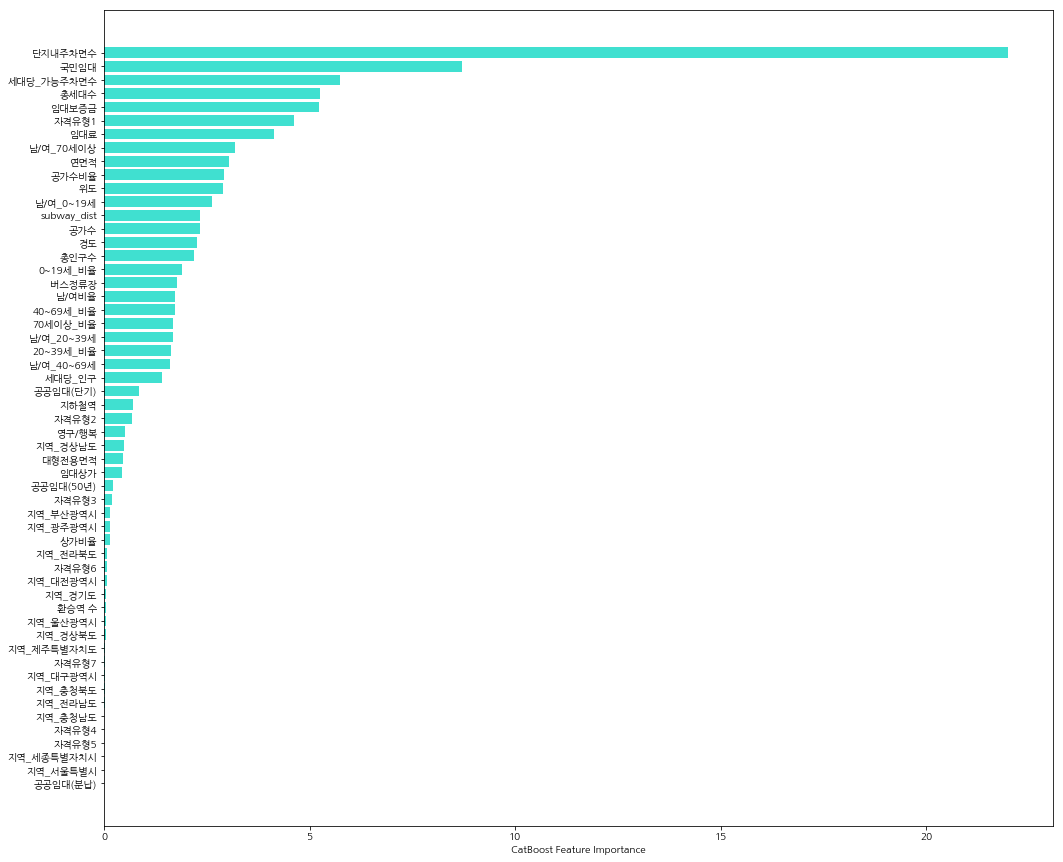

In [90]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model_1.feature_importances_.argsort()
plt.barh(X_test1.columns[sorted_feature_importance], 
        model_1.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

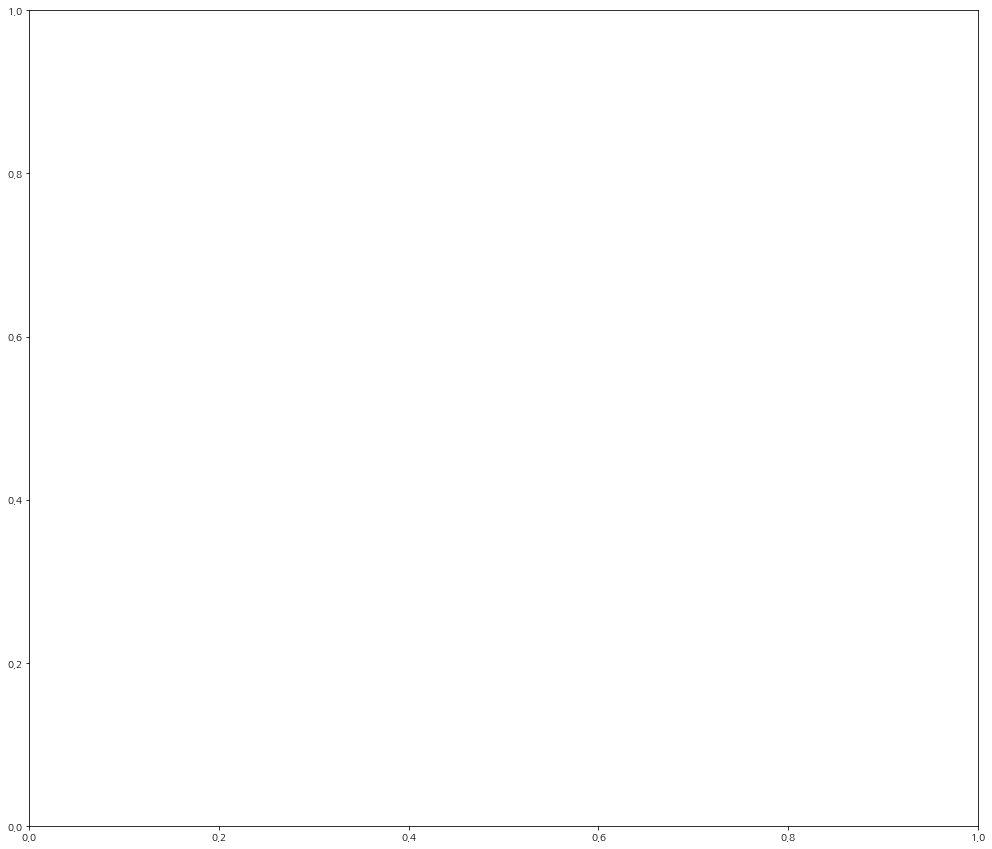

In [91]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model_2.feature_importances_.argsort()
plt.barh(X_test2.columns[sorted_feature_importance], 
        model_2.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [92]:
test_split.to_csv('0718_3.csv', index=False)